<center>
    <p style="font-family:PiliApp;font-size:30px;font-variant:small-caps;text-align:center;color:blue">
        Master Sciences du Numérique et Intelligence Artificielle<br>
        Module : Gouvernance et SI <br>
        Guide pour realiser cas pratique : <h3 color="red">Détection d’anomalies dans les logs du système d’exploitation à l’aide du dataset HDFS</h3>
    </p>
</center>


# Dataset utilisé : HDFS Log Dataset

<div style="background-color:#f8f9fa; border-left:4px solid #3498db; padding:15px; margin:20px 0;">

## Description
Le dataset HDFS Log est une collection de logs du système de fichiers Hadoop Distributed File System (HDFS). Il est couramment utilisé pour la recherche en analyse de logs et détection d'anomalies.

## Caractéristiques principales
- **Volume** : Contient des millions d'entrées de log HDFS
- **Annotations** : Inclut des étiquettes pour certaines séquences (anormal/normal)
- **Format** : Utilise un format standard de logs
- **Origine** : Généré à partir de clusters Hadoop en production

[Accéder au dataset sur GitHub](https://github.com/logpai/loghub/tree/master/HDFS)
</div>

## Utilisations typiques
- Détection d'anomalies dans les systèmes distribués
- Recherche en analyse de logs
- Développement de modèles de machine learning pour la maintenance prédictive
- Étude des patterns de comportement des systèmes distribués

## Structure du dataset
Le dataset est généralement organisé en fichiers texte contenant les lignes de log, avec des fichiers séparés pour les étiquettes (labels) indiquant les séquences normales et anormales.

# Partie 1 – Détection d’anomalies dans les logs HDFS par ML 


Le processus comprend :

---

### 📖 Lecture et parsing des logs HDFS
- Extraction des composants log avec des regex optimisées  
- Gestion des erreurs et statistiques de parsing  
- Échantillonnage optionnel pour traitement rapide  

---

### 🛠️ Feature Engineering avancé
- Nettoyage du texte (majuscules, nombres, ponctuation)  
- Création de features numériques (longueur des logs)  
- Encodage des catégories (niveaux et composants)  
- Vectorisation TF-IDF avec paramètres optimisés  

---

### 🧮 Préparation des données
- Combinaison des features en matrice sparse (mémoire optimisée)  
- Simulation de labels anomalies pour l'évaluation  
- Rééquilibrage des classes par sous-échantillonnage  

---

### 🤖 Modélisation multi-approches

#### 🔹 Isolation Forest (non supervisé)
- Détection automatique des outliers  
- Paramètres ajustés pour performance  

#### 🔹 Random Forest (supervisé)
- Entraînement sur données rééquilibrées  
- Optimisation des hyperparamètres  

---

### 📊 Évaluation et visualisation
- Métriques précises (`classification_report`)  
- Matrices de confusion visualisées  
- Comparaison des deux approches  

---

### 💾 Sauvegarde des résultats
- Export des prédictions et métriques  
- Persistance des modèles entraînés  



Chemin du fichier: HDFS_2k.log
Fichier existe: True

Parsing terminé - Lignes totales: 2000
Lignes parsées avec succès: 2000 (100.0%)
Erreurs de parsing: 0

Aperçu des données parsées:
     Date    Time  PID Level                     Component  \
0  081109  203615  148  INFO  dfs.DataNode$PacketResponder   
1  081109  203807  222  INFO  dfs.DataNode$PacketResponder   
2  081109  204005   35  INFO              dfs.FSNamesystem   
3  081109  204015  308  INFO  dfs.DataNode$PacketResponder   
4  081109  204106  329  INFO  dfs.DataNode$PacketResponder   

                                             Content                   BlockId  
0  PacketResponder 1 for block blk_38865049064139...     blk_38865049064139660  
1  PacketResponder 0 for block blk_-6952295868487...  blk_-6952295868487656571  
2  BLOCK* NameSystem.addStoredBlock: blockMap upd...   blk_7128370237687728475  
3  PacketResponder 2 for block blk_82291938032499...   blk_8229193803249955061  
4  PacketResponder 2 for block blk_-

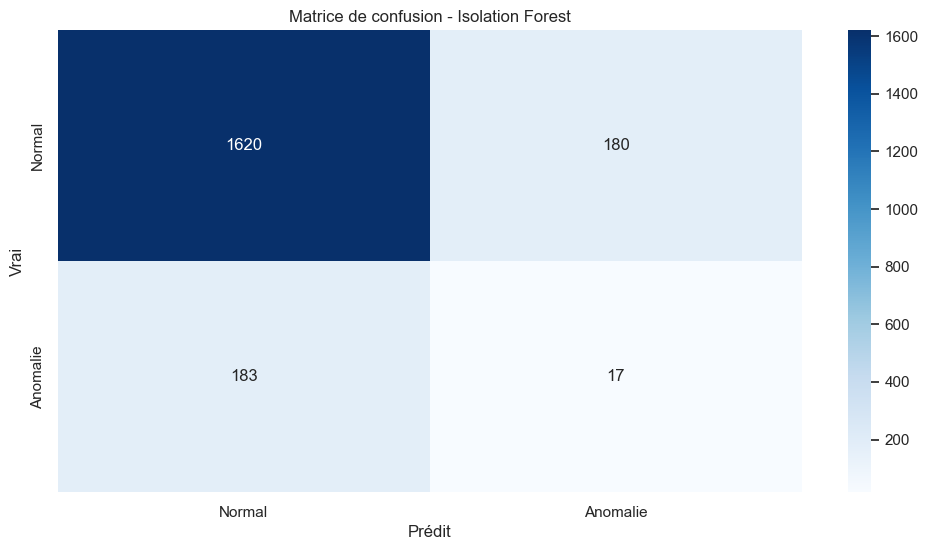


🌟 Rapport de classification Random Forest :
              precision    recall  f1-score   support

           0       0.51      0.52      0.51        62
           1       0.47      0.47      0.47        58

    accuracy                           0.49       120
   macro avg       0.49      0.49      0.49       120
weighted avg       0.49      0.49      0.49       120



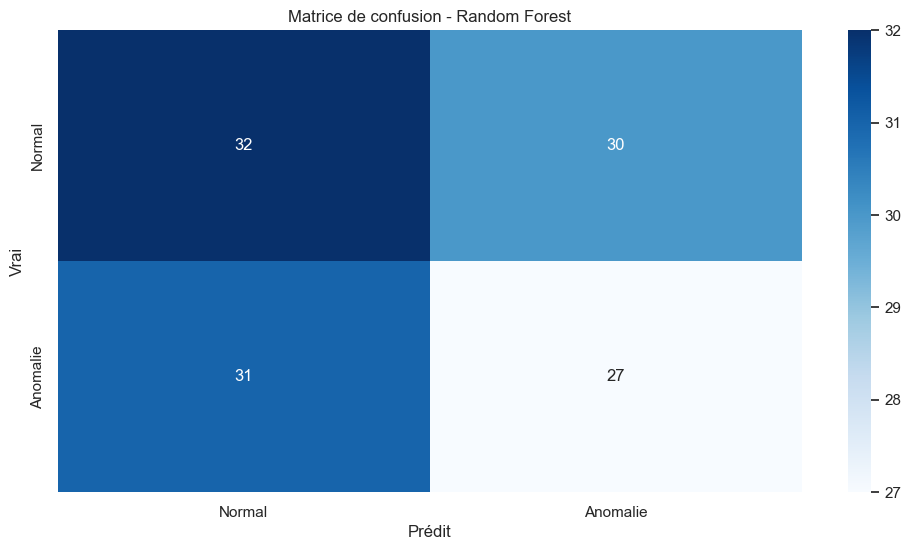


Résultats sauvegardés dans hdfs_anomaly_results.csv


In [1]:
# --- Importations des bibliothèques ---
import pandas as pd  # Manipulation de données tabulaires
import numpy as np  # Calculs numériques et matrices
import re  # Expressions régulières pour parsing de texte
import matplotlib.pyplot as plt  # Visualisation
import seaborn as sns  # Visualisation statistique
import os  # Opérations système (ex: vérifier l'existence d'un fichier)
import gc  # Garbage collection (libération mémoire)

from sklearn.preprocessing import LabelEncoder  # Encodage des variables catégorielles
from sklearn.feature_extraction.text import TfidfVectorizer  # Vectorisation de texte
from sklearn.ensemble import IsolationForest, RandomForestClassifier  # Modèles d’apprentissage
from sklearn.model_selection import train_test_split  # Division des données
from sklearn.metrics import classification_report, confusion_matrix  # Évaluation de modèle
from imblearn.under_sampling import RandomUnderSampler  # Réduction de classe majoritaire
from scipy.sparse import hstack, csr_matrix  # Manipulation de matrices creuses (sparse)
from sklearn.utils import resample  # Ré-échantillonnage manuel

# --- Configuration de l'affichage ---
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)  # Taille des graphiques

# --- Fonction de parsing des logs optimisée ---
def parse_hdfs_log(log_file, sample_size=None):
    """
    Extrait les champs Date, Heure, PID, Niveau, Composant, Contenu et BlockId depuis un fichier de logs HDFS.
    """
    log_pattern = re.compile(r"(?P<Date>\d{6})\s(?P<Time>\d{6})\s(?P<PID>\d+)\s(?P<Level>\w+)\s(?P<Component>[\w\.\$]+)\s*:\s(?P<Content>.+)")
    blk_pattern = re.compile(r"(blk_[-\d]+)")  # Identifier les identifiants de blocs HDFS

    parsed_logs = []
    line_count = 0
    error_count = 0

    with open(log_file, "r", encoding="utf-8") as f:
        for line in f:
            if sample_size and line_count >= sample_size:
                break

            line_count += 1
            try:
                match = log_pattern.match(line.strip())
                if match:
                    content = match.group("Content")
                    blk_match = blk_pattern.search(content)
                    parsed_logs.append({
                        **match.groupdict(), 
                        "BlockId": blk_match.group(1) if blk_match else None
                    })
            except:
                error_count += 1
                continue

    print(f"\nParsing terminé - Lignes totales: {line_count}")
    print(f"Lignes parsées avec succès: {len(parsed_logs)} ({len(parsed_logs)/line_count:.1%})")
    print(f"Erreurs de parsing: {error_count}")
    return pd.DataFrame(parsed_logs)

# --- Chargement des données ---
logfile = r"HDFS_2k.log"
print(f"\nChemin du fichier: {logfile}")
print(f"Fichier existe: {os.path.exists(logfile)}")

# Chargement avec échantillonnage pour test rapide
logs_df = parse_hdfs_log(logfile, sample_size=50000)
print("\nAperçu des données parsées:")
print(logs_df.head())

# --- Analyse exploratoire ---
logs_df["ContentLength"] = logs_df["Content"].str.len()
logs_df["LevelEncoded"] = LabelEncoder().fit_transform(logs_df["Level"])
logs_df["ComponentEncoded"] = LabelEncoder().fit_transform(logs_df["Component"].astype(str))

# --- Visualisation des distributions ---
def plot_distributions():
    # Niveau de log
    plt.figure()
    sns.countplot(data=logs_df, x="Level", order=logs_df["Level"].value_counts().index)
    plt.title("Distribution des niveaux de log")
    plt.show()

    # Composants les plus fréquents
    plt.figure()
    logs_df["Component"].value_counts().nlargest(10).plot(kind="barh")
    plt.title("Top 10 des composants")
    plt.gca().invert_yaxis()
    plt.show()

    # Longueur des messages
    plt.figure()
    sns.histplot(logs_df["ContentLength"], bins=30)
    plt.title("Distribution de la longueur des messages")
    plt.show()

# --- Nettoyage du texte ---
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()  # Minuscule
    text = re.sub(r'\d+', '', text)  # Supprimer les chiffres
    text = re.sub(r'\b\w{1,2}\b', '', text)  # Supprimer mots trop courts
    text = re.sub(r'[^\w\s]', '', text)  # Supprimer la ponctuation
    return text.strip()

logs_df["CleanedContent"] = logs_df["Content"].apply(clean_text)

# --- Vectorisation TF-IDF ---
tfidf = TfidfVectorizer(
    max_features=500,
    min_df=0.01,
    max_df=0.95,
    ngram_range=(1, 1),
    stop_words="english",
    dtype=np.float32
)
X_tfidf = tfidf.fit_transform(logs_df["CleanedContent"])

# --- Fusion avec les autres features numériques ---
X_extra = csr_matrix(logs_df[["ContentLength", "LevelEncoded", "ComponentEncoded"]].values)
X = hstack([X_tfidf, X_extra], format='csr')

# Libération mémoire
del X_tfidf, X_extra
gc.collect()

# --- Création de labels factices ---
logs_df["Label"] = 0  # Normal
np.random.seed(42)
anomaly_indices = np.random.choice(logs_df.index, size=int(0.1 * len(logs_df)), replace=False)
logs_df.loc[anomaly_indices, "Label"] = 1  # Anomalies
y = logs_df["Label"]

print(f"\n✅ Matrice finale shape: {X.shape}")

# --- Détection non supervisée : Isolation Forest ---
iso_forest = IsolationForest(
    contamination=0.1,
    n_estimators=100,
    max_samples='auto',
    random_state=42,
    n_jobs=-1
)
iso_forest.fit(X)
logs_df["Anomaly_Unsupervised"] = (iso_forest.predict(X) == -1).astype(int)

print("\n🔍 Résultats Isolation Forest :")
print(classification_report(y, logs_df["Anomaly_Unsupervised"]))

# --- Matrice de confusion personnalisée ---
def plot_confusion_matrix(cm, title):
    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=["Normal", "Anomalie"], 
                yticklabels=["Normal", "Anomalie"])
    plt.title(title)
    plt.ylabel("Vrai")
    plt.xlabel("Prédit")
    plt.show()

cm = confusion_matrix(y, logs_df["Anomaly_Unsupervised"])
plot_confusion_matrix(cm, "Matrice de confusion - Isolation Forest")

# --- Classification supervisée : Random Forest ---
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

# Division train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, 
    test_size=0.3, 
    random_state=42
)

rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# Évaluation
y_pred = rf.predict(X_test)
print("\n🌟 Rapport de classification Random Forest :")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, "Matrice de confusion - Random Forest")

# --- Sauvegarde des résultats ---
output_file = "hdfs_anomaly_results.csv"
logs_df.to_csv(output_file, index=False)
print(f"\nRésultats sauvegardés dans {output_file}")


# Partie 2– Détection d’anomalies dans les logs HDFS par DL


Le processus comprend :

---

### 📖 Lecture et normalisation des logs HDFS

-Extraction des modèles de logs avec des expressions régulières avancées
-Transformation en templates génériques (IP, chemins, identifiants en wildcards)
-Réduction de la dimensionnalité par regroupement de logs similaires
-Identification de 16 templates uniques sur 2000 lignes de logs

---

### 🔄 Création de séquences temporelles

-Fenêtre glissante de 5 événements consécutifs
-Encodage numérique des templates pour traitement ML
-Génération de 1995 séquences d'apprentissage
-Fractionnement en ensembles d'entraînement (80%) et validation (20%) 

---

### 🧠 Architecture neuronale LSTM

-Couche d'embedding (64 dimensions) pour représentation vectorielle des templates
-Double couche LSTM (128 puis 64 neurones) pour capturer les dépendances temporelles
-Dropout stratégique (20%) pour limiter le surapprentissage
-Couche de sortie avec activation softmax pour la prédiction probabiliste

---

### 📈 Entraînement optimisé

-20 époques avec batch size de 32 pour équilibrer vitesse et précision
-Optimiseur Adam avec categorical cross-entropy
-Monitoring des métriques d'entraînement et validation
-Visualisation des courbes de perte et précision pour analyse de convergence 

---

### 🔍 Détection multi-critères des anomalies

-Analyse des séquences de validation avec 3 règles de détection:
-Faible confiance (probabilité < 30%)
-Prédiction incorrecte (séquence attendue vs prédite)
-Absence dans le top-3 des prédictions
-Identification de 239 anomalies sur 399 séquences de validation 

---

### 📊 Visualisation et analyse des résultats

-Matrice de confusion pour évaluation globale des prédictions
-Affichage détaillé des anomalies avec contexte complet
-Export CSV des anomalies pour analyse approfondie
-Mapping des templates pour référence et interprétation 

---

### 💾 Export et persistance

-Sauvegarde du modèle entraîné pour déploiement
-Export des courbes de performance pour documentation
-Génération de fichiers CSV pour intégration avec d'autres outils d'analyse


[INFO] Logs parsés : 2000 lignes | 16 templates uniques
[INFO] Total séquences créées : 1995


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.2898 - loss: 2.5152 - val_accuracy: 0.3584 - val_loss: 1.6284
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3729 - loss: 1.6938 - val_accuracy: 0.3709 - val_loss: 1.5706
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4004 - loss: 1.5203 - val_accuracy: 0.3960 - val_loss: 1.4873
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3905 - loss: 1.4516 - val_accuracy: 0.4085 - val_loss: 1.4844
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3958 - loss: 1.5036 - val_accuracy: 0.4010 - val_loss: 1.4535
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4182 - loss: 1.3771 - val_accuracy: 0.4060 - val_loss: 1.4552
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4115 - loss: 1.4196 - val_accuracy: 0.4110 - val_loss: 1.4282
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4172 - loss: 1.3926 - val_accuracy: 0.4010 - val

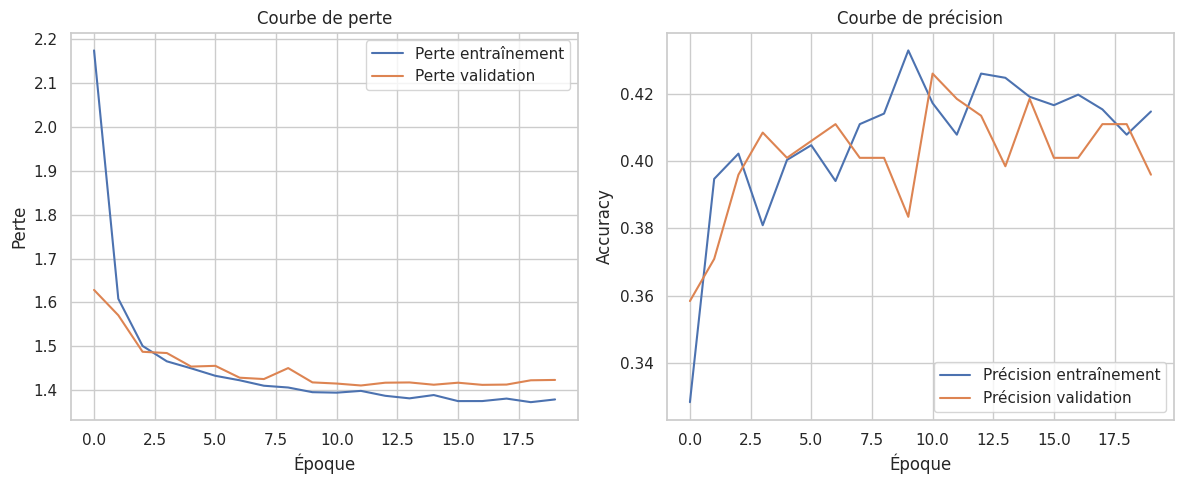

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step

📌 241 anomalies détectées (sur 399 séquences)


🔴 Anomalie #1 (mauvaise prédiction)
 - * info dfs.fsdataset: deleting block blk_* file <PATH>*
 - * info dfs.fsdataset: deleting block blk_* file <PATH>*
 - * info dfs.datanode$packetresponder: packetresponder * for block blk_* terminating
 - * info dfs.fsdataset: deleting block blk_* file <PATH>*
>>> Prédit : * info dfs.fsdataset: deleting block blk_* file <PATH>*
    Réel   : * info dfs.datanode$dataxceiver: receiving block blk_* src: <PATH>:* dest: <PATH>:*
    Confiance : 0.8188

🔴 Anomalie #2 (faible confiance)
 - * info dfs.fsnamesystem: block* namesystem.allocateblock: <PATH> blk_*
 - * info dfs.datanode$packetresponder: received block blk_* of size * from <PATH>
 - * info dfs.fsnamesystem: block* namesystem.addstoredblock: blockmap updated: IP:PORT is added to blk_* size *
 - * info dfs.datanode$packetresponder: packetresponder * for block blk_* terminating
>>> Prédit : * info dfs.datanode$

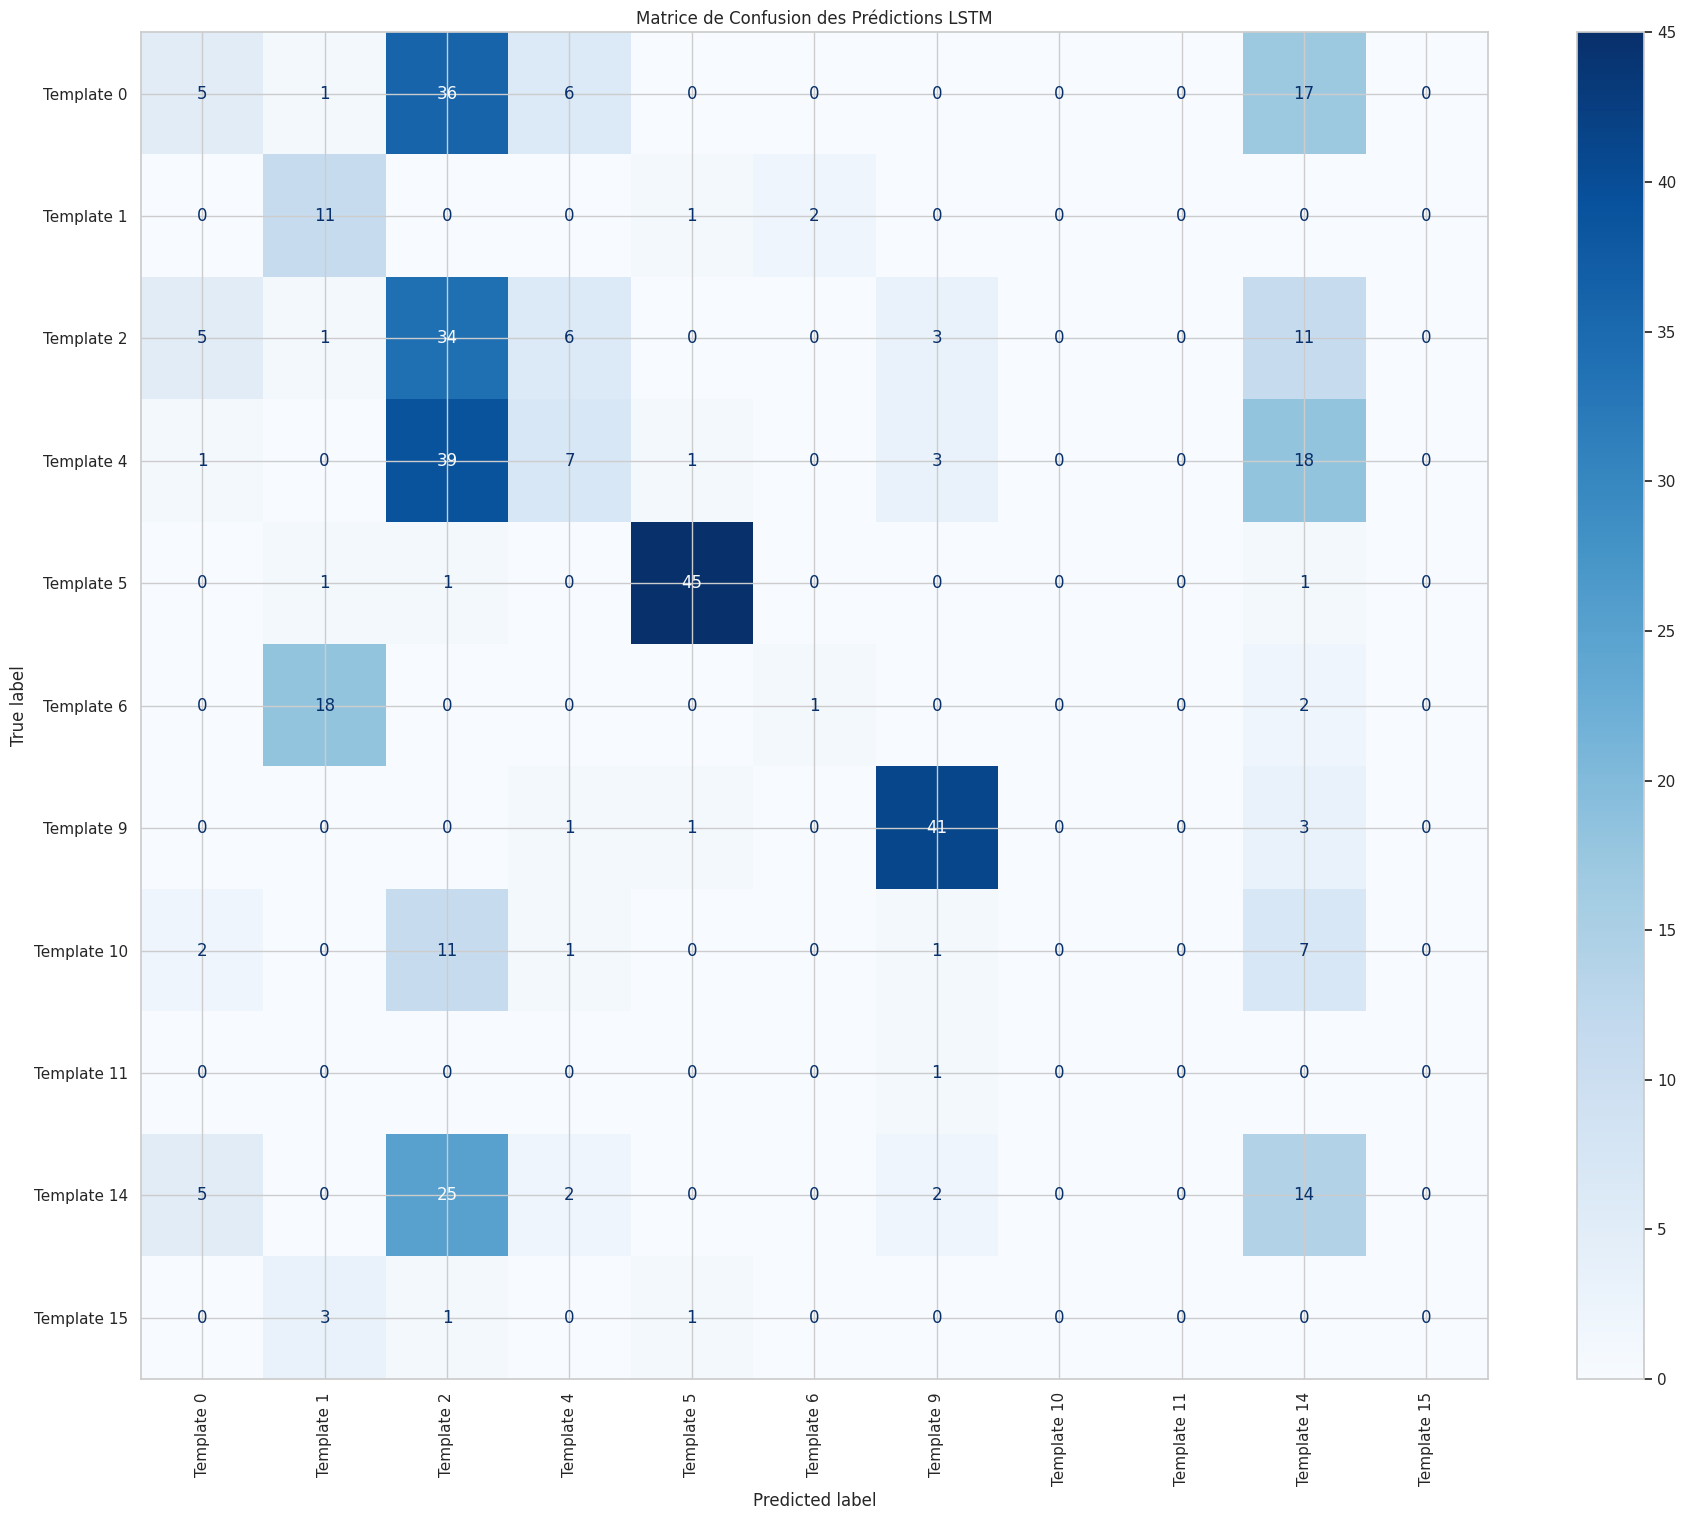


✅ Fichier template_mapping.csv exporté avec succès !


In [3]:
# Importation des bibliothèques nécessaires
import numpy as np
import re
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dropout, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib as mpl

# Résoudre les problèmes d'affichage de certaines polices (pour les graphes)
mpl.rcParams['font.family'] = 'DejaVu Sans'

# =========================
# 1. PARSING DES LOGS
# =========================

# Chemin vers le fichier de logs à analyser
logfile = r"HDFS_2k.log"

def parse_template(log):
    """
    Fonction de normalisation des lignes de log :
    remplace les éléments variables (IP, chemins, nombres, etc.)
    par des tokens génériques pour obtenir un template standardisé.
    """
    log = log.lower().strip()
    log = re.sub(r'blk_[\-\d]+', 'blk_*', log)  # Identifiants de blocs
    log = re.sub(r'/[a-z0-9_\-/.]+', '<PATH>', log)  # Chemins
    log = re.sub(r'([0-9]+\.[0-9]+\.[0-9]+\.[0-9]+):[0-9]+', 'IP:PORT', log)  # IP:PORT
    log = re.sub(r'([0-9]+\.[0-9]+\.[0-9]+\.[0-9]+)', 'IP', log)  # IP seule
    log = re.sub(r'size \d+', 'size *', log)  # Taille de fichiers
    log = re.sub(r'\d{6} \d{6}', '', log)  # Horodatages spécifiques
    log = re.sub(r'\d+', '*', log)  # Tous les autres nombres
    return log.strip()

# Lecture et parsing de toutes les lignes du fichier log
with open(logfile, "r") as f:
    raw_logs = [parse_template(line) for line in f.readlines()]

print(f"[INFO] Logs parsés : {len(raw_logs)} lignes | {len(set(raw_logs))} templates uniques")

# =========================
# 2. ENCODAGE & SÉQUENCES
# =========================

# Création du dictionnaire de mapping template <-> entier
unique_templates = list(set(raw_logs))
template_to_int = {tpl: i for i, tpl in enumerate(unique_templates)}
int_to_template = {i: tpl for tpl, i in template_to_int.items()}

window_size = 5  # Nombre de lignes utilisées pour prédire la suivante
sequences = []

# Génération des séquences glissantes (ex : [L1, L2, L3, L4] => prédire L5)
for i in range(len(raw_logs) - window_size):
    seq = [template_to_int[raw_logs[i + j]] for j in range(window_size)]
    sequences.append(seq)

print(f"[INFO] Total séquences créées : {len(sequences)}")

# Séparation des entrées (X) et des cibles (y)
X = np.array([seq[:-1] for seq in sequences])  # Séquence sans le dernier
y = np.array([seq[-1] for seq in sequences])   # Prédiction = dernier élément

# Découpage en jeu d'entraînement et de validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# =========================
# 3. MODÈLE LSTM
# =========================

vocab_size = len(unique_templates)     # Nombre de templates différents
embedding_dim = 64                     # Dimension de l'espace d'embedding

# Définition du modèle LSTM séquentiel
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),  # Apprentissage des représentations
    LSTM(128, return_sequences=True),                            # Première couche LSTM
    Dropout(0.2),                                                # Régularisation
    LSTM(64),                                                    # Deuxième couche LSTM
    Dropout(0.2),
    Dense(vocab_size, activation='softmax')                      # Prédiction du prochain template
])

# Compilation du modèle
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()  # Affiche la structure du modèle

# =========================
# 4. ENTRAÎNEMENT
# =========================

# Entraînement du modèle sur les données de log séquentielles
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

# =========================
# 5. COURBES DE PERFORMANCES
# =========================

plt.figure(figsize=(12, 5))

# Courbe de la perte
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Perte entraînement')
plt.plot(history.history['val_loss'], label='Perte validation')
plt.title('Courbe de perte')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.legend()

# Courbe de précision
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Précision entraînement')
plt.plot(history.history['val_accuracy'], label='Précision validation')
plt.title('Courbe de précision')
plt.xlabel('Époque')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('performance_curves.png')  # Enregistrement de la figure
plt.show()

# =========================
# 6. DÉTECTION D'ANOMALIES
# =========================

# Prédictions du modèle sur l'ensemble de validation
predictions = model.predict(X_val)
anomalies = []

# Paramètres de détection
top_k = 3              # Si la prédiction réelle n'est pas dans le top_k => anomalie
confidence_thr = 0.3   # Si la probabilité est trop faible => anomalie

# Analyse des prédictions pour détecter les anomalies
for i in range(len(predictions)):
    predicted_index = np.argmax(predictions[i])
    actual_index = y_val[i]
    prob = np.max(predictions[i])
    top_preds = np.argsort(predictions[i])[-top_k:]

    anomaly = False
    reason = ""

    # Trois règles pour considérer une prédiction comme anormale
    if predicted_index != actual_index and prob < confidence_thr:
        anomaly = True
        reason = "faible confiance"
    elif predicted_index != actual_index:
        anomaly = True
        reason = "mauvaise prédiction"
    elif actual_index not in top_preds:
        anomaly = True
        reason = "pas dans top-3"

    if anomaly:
        anomalies.append({
            'sequence': X_val[i],
            'predicted': int_to_template[predicted_index],
            'actual': int_to_template[actual_index],
            'confidence': prob,
            'reason': reason
        })

print(f"\n📌 {len(anomalies)} anomalies détectées (sur {len(X_val)} séquences)\n")

# Affichage des 5 premières anomalies
for i, anomaly in enumerate(anomalies[:5]):
    print(f"\n🔴 Anomalie #{i+1} ({anomaly['reason']})")
    for idx in anomaly['sequence']:
        print(f" - {int_to_template[idx]}")
    print(f">>> Prédit : {anomaly['predicted']}")
    print(f"    Réel   : {anomaly['actual']}")
    print(f"    Confiance : {anomaly['confidence']:.4f}")

# =========================
# 7. EXPORT CSV DES ANOMALIES
# =========================

# Sauvegarde des anomalies dans un fichier CSV pour analyse ultérieure
anomaly_data = []

for anomaly in anomalies:
    anomaly_data.append({
        'Sequence': ' | '.join([int_to_template[idx] for idx in anomaly['sequence']]),
        'Prédit': anomaly['predicted'],
        'Réel': anomaly['actual'],
        'Confiance': round(anomaly['confidence'], 4),
        'Raison': anomaly['reason']
    })

df_anomalies = pd.DataFrame(anomaly_data)
df_anomalies.to_csv("anomalies_detectees.csv", index=False, encoding='utf-8')
print("\n✅ Fichier anomalies_detectees.csv exporté avec succès !")

# =========================
# 8. MATRICE DE CONFUSION
# =========================

# Création et affichage de la matrice de confusion
y_true = y_val
y_pred = [np.argmax(pred) for pred in predictions]

# Limiter les labels aux templates réellement utilisés
unique_labels = sorted(list(set(y_true) | set(y_pred)))
display_labels = [int_to_template[i] for i in unique_labels]

# Création de la matrice de confusion
cm = confusion_matrix(y_true, y_pred, labels=unique_labels)

plt.figure(figsize=(20, 16))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(include_values=True, cmap="Blues", ax=plt.gca())

# Réduction des noms sur les axes pour lisibilité
ax = plt.gca()
short_labels = ["Template " + str(i) for i in unique_labels]
ax.set_xticklabels(short_labels, rotation=90)
ax.set_yticklabels(short_labels)

plt.title("Matrice de Confusion des Prédictions LSTM")
plt.tight_layout(pad=3.0)
plt.savefig('confusion_matrix.png', bbox_inches='tight')
plt.show()

# =========================
# 9. DÉTAILS DES TEMPLATES
# =========================

# Sauvegarde d’un mapping Template <-> Texte réel
template_dict = {f"Template {i}": template for i, template in int_to_template.items()}
df_templates = pd.DataFrame(list(template_dict.items()), columns=['ID', 'Template'])
df_templates.to_csv("template_mapping.csv", index=False, encoding='utf-8')
print("\n✅ Fichier template_mapping.csv exporté avec succès !")
